Это мой проект сделанный самостоятельно с нуля в рамках работы над проектами для курса Введение в физически информированные нейронные сети в Школе анализа данных Яндекса. 

Цель проекта была придумать и реализовать нейросеть для решения здачи поиска собственных функция дифферециального оператора и провести эксперименты.

In [9]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output
from IPython.display import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Для решение этой проблемы будем использовать MLP на вход ктоторому подаётся батч точек размера m и дабавляется n векторов эбмедингов кодирующиз раличные собственные функции. В итоге получается бат размера (m,n), который передаётся в mlp сесть на выходе получается батч (m,n) значений функций $u$, т.е. $u_i(x_j), j = 1\dots m, i = 1\dots n.$
Так же сеть возвращается набор обучаемых параметров $\lambda_1,\dots,\lambda_n$ предсказанных собственных чисел, они вместе с функциями $u$ отправляются в функцию потерь.

![Архитектура сети](./net_arcitecture.png)

In [3]:
# стандартная MLP, собственные вектора кодируеются эмбедингами, собственные значения хранятся как отдельный тензор параметров


class MLPEmbde(nn.Module):
    def __init__(
        self,
        num_emb,
        in_dim,
        hiden_dim,
        depth,
        emb_dim,
        init_interval,
        activation=nn.Tanh(),
    ):
        """
        num_emb - число собственных фукнций для выучивания
        in_dim - размерность пространства
        hiden_dim - размер внутренних слоев
        depth - глубина
        emb_dim - размерность пространства эмбедингов
        init_interval - начальные значения собственных значений инициализируется случайными числами на отрезке [0,init_interval]
        activation - функция активации
        """
        super().__init__()
        self.num_emb = num_emb
        self.hiden_dim = hiden_dim
        self.emb_dim = emb_dim
        self.activation = activation
        self.in_dim = in_dim
        self.init_interval = init_interval
        self.depth = depth

        eigen_val = torch.rand(num_emb) * init_interval
        self.eigen_val = nn.Parameter(eigen_val)

        self.eigen_embed = nn.Embedding(num_emb, emb_dim)

        layers = []
        layers += [nn.Linear(in_dim + emb_dim, hiden_dim), activation]
        for _ in range(depth - 1):
            layers += [nn.Linear(hiden_dim, hiden_dim), activation]
        layers += [nn.Linear(hiden_dim, 1)]
        net = nn.Sequential(*layers)

        self.net = net

    def forward(self, x):
        """
        x - батч точек размера (n,in_dim)

        возвращает значения собственных функций вычисленных в точка x
        тензон размера (num_emb,n) и собственные значения тензор размера (num_emb,)
        """
        n_points = x.shape[0]

        arange = torch.arange(0, self.num_emb, dtype=torch.int32)
        arange = arange.to(x.device)
        eigen_embeddings = self.eigen_embed(arange)
        eigen_embeddings = eigen_embeddings[:, None, :]
        eigen_embeddings = torch.repeat_interleave(eigen_embeddings, n_points, dim=1)

        x = x[None, :, :]
        x = torch.repeat_interleave(x, self.num_emb, dim=0)

        combined_x = torch.cat([x, eigen_embeddings], dim=-1)

        result = self.net(combined_x)

        result = torch.squeeze(result, dim=-1)
        # выход имеер рамзеры result - (количество собственных векторов,количество точек)
        # eigen_val - (количество собственных векторов)
        return result, self.eigen_val

#### Функции потерь

Обозначим через $||u_i||$ - $L_2$ норма функции $u_i.$

$$\mathrm{normal \; loss} = \frac{1}{M} \sum_{i=1}^M \left( \frac{1}{||u_i||^2} + ||u_i||^2 - 2 \right)$$
Лосс на норму функции нужен чтобы не дать сетке выучить всё нулями, он сильно выталкивает функции из нулевой нормы, в идеале мы хотим получить функции с единичной нормой.

$$\mathrm{dot \; product \; loss} = \frac{2}{M(M-1)} \sum^M_{i< j:\; i,j = 1}\left(\frac{1}{1+\varepsilon-\cos^2 \theta_{ij}} - \frac{1}{\varepsilon}\right),$$
где $\theta_{ij}$ - угол между собственным функциями $u_i$ и $u_j$ и $\varepsilon$ - малый параметр для численной стабильности.
Лосс на скалярное произведение нужен для того чтобы не дать сетке выучить одинаковые функции, он сильно расталкивает друг от друга функции с нулевым углом между ними, в идеале мы хотим получить набор отрогональных функций.


Граничный лосс нужен из физических соображений, и соотвествует одному из трех граничных условий: условия Дирихле, условия  Неймана или периодические условия.
Условия Дирихле:
$$\mathrm{boundar \; loss} = \sum_{x_i \in \partial \Omega} ||u(x_i)||^2$$

Условия  Неймана на отрезке $[0,a]:$
$$\mathrm{boundar \; loss} = ||u'(0)||^2 +||u'(a)||^2$$

Периодические условия на отрезке $[0,a]:$
$$\mathrm{boundar \; loss} = ||u(0)-u(a)||^2 + ||u'(0)-u'(a)||^2$$

"Физическая" функция потерь
$$\mathrm{PINN \; loss} = \sum_i ||L u_i -  \lambda_i u_i||^2,$$
где $L$ какой-то дифференциальный оператор, на практике рассматривались одномерный и двумерный оператор Лапласа.

Общий лосс нейросети сумма с подходящими коэффициентами этих лоссов 
$$\mathrm{loss} = \mathrm{normal \; loss} + \mathrm{dot \; product \; loss} + \mathrm{boundar \; loss}  + \mathrm{PINN \; loss}$$




In [4]:
# различные компоненты функции потерь


def normal_loss(u):
    """
    Функция для вычисления потерь связанных с нормами функций
    u - (M,N)-тензор, M - число собственныз функци, N - число значений каждой функции
    Возвращает norm_loss

    """

    norm = torch.mean(u**2, dim=1)
    loss = torch.mean(1 / norm + norm - 2)

    return loss


def dot_product_loss(u, eps=1e-2):
    """Функция для вычисления потерь связанных с попарными скалярными произведениями
    u - (M,N)-тензор, M - число собственныз функци, N - число значений каждой функции
    eps - малая константа для численной стабильности вычислений
    Возвращает dot_product_loss
    """

    n_eigenval = u.shape[0]
    n_points = u.shape[1]
    norm = torch.mean(u**2, dim=1)
    u = u / norm[:, None] ** 0.5
    dot_pords = (
        torch.triu(u @ torch.transpose(u, -1, -2), diagonal=1) ** 2 / n_points**2
    )
    loss = torch.sum(1 / (1 + eps - dot_pords) - 1 / (1 + eps)) / (
        n_eigenval * (n_eigenval - 1) / 2
    )

    return loss


def boundary_loss(u, x=None, condtion_type="zero"):
    """
    вычисляет граничные потери
    u - (M,N)-тензор, M - число собственныз функци, N - число значений каждой функции
    x - (N,dim) тензор точек в которых были вычисленны функции u
    condtion_type - тип граничных условий
    """
    if condtion_type == "zero":
        return torch.mean(torch.mean(u**2, dim=1))
    elif condtion_type == "periodic":
        u_x = torch.zeros_like(u)
        n_eign = u.shape[0]
        for i in range(n_eign):
            u_i = u[i]
            ones = torch.ones_like(u_i)
            grad_i = torch.autograd.grad(
                u_i, x, grad_outputs=ones, create_graph=True, retain_graph=True
            )[0].squeeze(dim=1)
            u_x[i] = grad_i

        return torch.mean((u[:, 0] - u[:, 1]) ** 2) + torch.mean(
            (u_x[:, 0] - u_x[:, 1]) ** 2
        )
    elif condtion_type == "neuman":
        u_x = torch.zeros_like(u)
        n_eign = u.shape[0]
        for i in range(n_eign):
            u_i = u[i]
            ones = torch.ones_like(u_i)
            grad_i = torch.autograd.grad(
                u_i, x, grad_outputs=ones, create_graph=True, retain_graph=True
            )[0].squeeze(dim=1)
            u_x[i] = grad_i

        return torch.mean(torch.mean(u_x**2, dim=1))
    else:
        raise ValueError("condtion_type must be 'zero' or 'neuman' or 'periodic'.")


def pde_laplace_1D_loss(
    x: torch.Tensor, l: torch.Tensor, u: torch.Tensor
) -> torch.Tensor:
    """вычисляет PINN-loss для задачи задачи нахождения собственны числе в одномерном Лапласе
    x - тензор размера (количество точек,1) - точки в которых вычисляется фунция
    l - тензор размера (количество собственных векторов,) - набор собственных значений
    u - (количество собственных векторов,количество точек) - набор значений собственных функций вычисленных в точках x
    """
    u_x = torch.zeros_like(u)
    n_eign = u.shape[0]

    for i in range(n_eign):
        u_i = u[i]
        ones = torch.ones_like(u_i)
        grad_i = torch.autograd.grad(
            u_i, x, grad_outputs=ones, create_graph=True, retain_graph=True
        )[0].squeeze(dim=1)
        u_x[i] = grad_i

    u_xx = torch.zeros_like(u)

    for i in range(n_eign):
        u_i = u_x[i]
        ones = torch.ones_like(u_i)
        grad_i = torch.autograd.grad(
            u_i, x, grad_outputs=ones, create_graph=True, retain_graph=True
        )[0].squeeze(dim=1)
        u_xx[i] = grad_i

    return torch.mean(torch.mean((u_xx + l[:, None] * u) ** 2, dim=1))


def pde_laplace_2D_loss(
    x: torch.Tensor, l: torch.Tensor, u: torch.Tensor
) -> torch.Tensor:
    """вычисляет PINN-loss для задачи задачи нахождения собственны числе в двумерном Лапласе
    x - тензор размера (количество точек,2) - точки в которых вычисляется фунция
    l - тензор размера (количество собственных векторов,) - набор собственных значений
    u - (количество собственных векторов,количество точек) - набор значений собственных функций вычисленных в точках x
    """
    u_x = torch.zeros_like(u)
    u_y = torch.zeros_like(u)
    n_eign = u.shape[0]

    for i in range(n_eign):
        u_i = u[i]
        ones = torch.ones_like(u_i)
        grad_i = torch.autograd.grad(
            u_i, x, grad_outputs=ones, create_graph=True, retain_graph=True
        )[0]
        u_x[i] = grad_i[:, 0]
        u_y[i] = grad_i[:, 1]
    u_xx = torch.zeros_like(u)
    u_yy = torch.zeros_like(u)

    for i in range(n_eign):
        grad_i = u_x[i]
        ones = torch.ones_like(grad_i)
        grad_i = torch.autograd.grad(
            grad_i, x, grad_outputs=ones, create_graph=True, retain_graph=True
        )[0][:, 0]
        u_xx[i] = grad_i

        grad_i = u_y[i]
        ones = torch.ones_like(grad_i)
        grad_i = torch.autograd.grad(
            grad_i, x, grad_outputs=ones, create_graph=True, retain_graph=True
        )[0][:, 1]
        u_yy[i] = grad_i

    return torch.mean(torch.mean((u_xx + u_yy + l[:, None] * u) ** 2, dim=1))

In [5]:
# генерация точек


def generate_data_int(n_points=100, dim=1, sacle=None):
    """
    генерирует равномерное распеделение точек внутри параллепипеда.
    n_points - число точек
    dim - число координат
    sacle - None или массив размера (dim),
    если None генерирует точки из единичного куба [0,1]*...*[0,1]
    иначе из параллепипеда [0,sacle[0]]*...*[0,sacle[dim-1]]

    возвращает тензор размера (n_points,dim)
    """

    x_int = torch.rand((n_points, dim))

    if sacle is not None:
        for ind, val in enumerate(sacle):
            x_int[:, ind] *= val

    x_int.requires_grad_(True)
    x_int = x_int.to(device)

    return x_int


def generate_data_bd_2d(n_points=100, sacle=None):
    """
    генерирует равномерное распеделение точек на границе двумерного прямоугольника .
    n_points - число точек на каждой стороне
    sacle - None или массив размера (2),
    если None генерирует точки на гранях квадрата [0,1]*[0,1]
    иначе на гранях праямоугльника [0,sacle[0]]*[0,sacle[1]]

    возвращает тензор размера (n_points,dim)
    """

    x0 = torch.cat([torch.rand(n_points, 1), torch.zeros(n_points, 1)], dim=1)
    y0 = torch.cat([torch.zeros(n_points, 1), torch.rand(n_points, 1)], dim=1)
    x1 = torch.cat([torch.rand(n_points, 1), torch.ones(n_points, 1)], dim=1)
    y1 = torch.cat([torch.ones(n_points, 1), torch.rand(n_points, 1)], dim=1)
    combinded = torch.cat([x0, y0, x1, y1])

    if sacle is not None:
        for ind, val in enumerate(sacle):
            combinded[:, ind] *= val
    combinded = combinded.to(device)
    return combinded

In [6]:
# различные функции отрисовки


def draw_loss(history, skip_fitst=200):
    """
    рисует графики функции потерь
    """
    # отрисовка потерь
    ep = history["ep"][skip_fitst:]
    for key, val in history.items():
        if key != "ep":
            plt.plot(ep, val[skip_fitst:], label=key)
    plt.title("Loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()


def draw_eigenfunc_1D(model):
    """
    рисует собственные функции на отрезке [0,1] в одномерном эксперименте
    model - нейросете для предсказания собственных функций
    """
    x_int_test = torch.arange(0, 1, 0.01)
    x_int_test = x_int_test[:, None]
    x_int_test = x_int_test.to(device)
    with torch.no_grad():
        u_int, l = model(x_int_test)
    y = u_int.cpu().detach().numpy()
    print("norms of eigenfunctions:")
    for i in range(y.shape[0]):
        print(f"|u_{i+1}|^2= ", np.mean(y[i, :] ** 2))
    for i in range(y.shape[0]):
        plt.plot(x_int_test.cpu().detach().numpy(), y[i, :])
    plt.title("Eigenfunctions")
    plt.xlabel("x")
    plt.show()


def generate_grid(n_steps=100, sacle=None):
    xs = torch.linspace(0, 1, steps=n_steps)
    ys = torch.linspace(0, 1, steps=n_steps)
    x, y = torch.meshgrid(xs, ys, indexing="xy")
    xy = torch.cat([x.flatten()[:, None], y.flatten()[:, None]], dim=1)

    if sacle is not None:
        for ind, val in enumerate(sacle):
            xy[:, ind] = xy[:, ind] * val
    xy = xy.to(device)
    return xy


def heatmap(u, x_dim, y_dim):
    # u = u.cpu().detach().numpy()
    n_plots = u.shape[0]
    u = u.reshape((n_plots, x_dim, y_dim))
    n_row = n_plots // 3 if n_plots % 3 == 0 else 1 + n_plots // 3
    fig, axs = plt.subplots(n_row, 3)
    if n_row == 1:
        for i in range(n_plots):
            axs[i].imshow(u[i], cmap="viridis", interpolation="bilinear")
    else:
        for i in range(n_plots):
            axs[i // 3, i % 3].imshow(u[i], cmap="viridis", interpolation="bilinear")
    fig.show()
    plt.show()


def draw_eigenfunc_2D(model, sacle=None):
    # отрисовка собственных функций
    x_grid = generate_grid(100, sacle)
    with torch.no_grad():
        u_int, l = model(x_grid)
    z = u_int.cpu().detach().numpy()

    for i in range(z.shape[0]):
        print(f"|u_{i+1}|^2= ", np.mean(z[i, :] ** 2))
    heatmap(z, 100, 100)

Эксперименты с одномерным лаплассом.

In [ ]:
# инициализация сетки
lr = 1e-3
model = MLPEmbde(
    num_emb=3, in_dim=1, hiden_dim=64, depth=4, emb_dim=32, init_interval=20
)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)

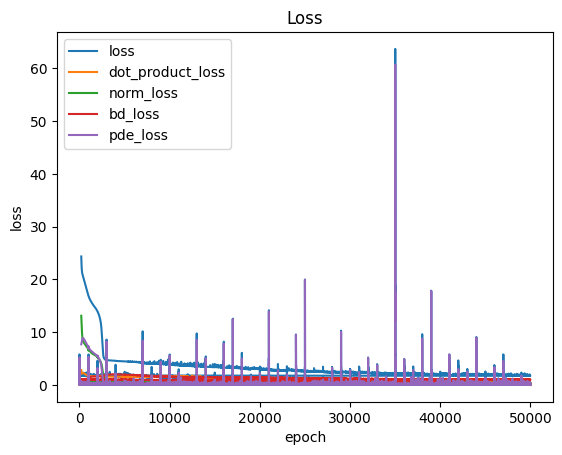

eigenval =  1.9993 2.9505 1.004
norms of eigenfunctions:
|u_1|^2=  0.98905253
|u_2|^2=  0.94794005
|u_3|^2=  1.048515


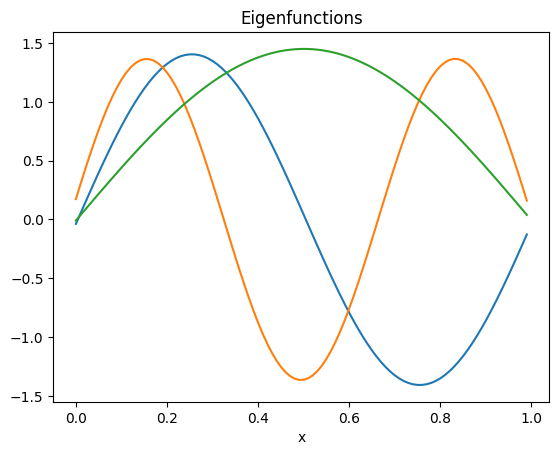

Training: 100%|██████████| 50001/50001 [18:00<00:00, 46.29it/s, loss=5.0709e-02]


In [ ]:
# Петля обучения

from collections import defaultdict

n_points = 500
# весовые коэффиценты разных компонент лоса
bd_cf = 5
norm_cf = 1
pde_cf = 1
dot_cf = 5

x_int = generate_data_int(n_points)

x_b = torch.Tensor([0, 1])
x_b = x_b[:, None]
x_b.requires_grad_(True)
x_b = x_b.to(device)

epochs = 50000
pbar = trange(epochs + 1, desc="Training")
history = defaultdict(list)
for ep in pbar:
    if ep % 1000 == 0 and ep > 0:
        x_int = generate_data_int(n_points)
    opt.zero_grad()

    u_int, l = model(x_int)
    u_b, _ = model(x_b)

    norm_loss = normal_loss(u_int)
    dp_loss = dot_product_loss(u_int)
    bd_loss = boundary_loss(u_b, condtion_type="zero")
    pde_loss = pde_laplace_1D_loss(x_int, l, u_int)

    loss = dot_cf * dp_loss + norm_cf * norm_loss + bd_cf * bd_loss + pde_cf * pde_loss
    loss.backward()
    opt.step()

    history["ep"].append(ep)
    history["loss"].append(float(loss.item()))
    history["dot_product_loss"].append(float(dot_cf * dp_loss.item()))
    history["norm_loss"].append(float(norm_cf * norm_loss.item()))
    history["bd_loss"].append(float(bd_cf * bd_loss.item()))
    history["pde_loss"].append(float(pde_cf * pde_loss.item()))
    if ep % 1000 == 0 and ep > 0:
        clear_output()
        draw_loss(history)
        print(
            "eigenval = ",
            " ".join(str(round(float(x), 4)) for x in (l / torch.pi**2) ** 0.5),
        )
        draw_eigenfunc_1D(model)

    pbar.set_postfix(loss=f"{loss.item():.4e}")

eigenval - это $\sqrt{\lambda_i/\pi^2}$ - теория говорит что это должны быть числа $1,2,3,\dots$, так и получилось.
Собственные функции должны быть арками синусов, что тоже удалось получить.

In [ ]:
def save_model(model, filepath):
    """
    Сохраняет всю модель
    """
    torch.save(model, filepath)
    print(f"Модель сохранена в {filepath}")


def load_model(filepath):
    """
    Загружает всю модель
    """
    model = torch.load(filepath, weights_only=False)
    print(f"Модель загружена из {filepath}")
    return model

In [ ]:
filepath = "model_laplace_1d_3_eginval_neuman.pth"
save_model(model, filepath)

Модель сохранена в model_laplace_1d_3_eginval_neuman.pth


Двумерный случай. Проведем эксперименты для двумерного уравнения Лапласа.

In [7]:
# инициализация сетки
lr = 1e-3
model = MLPEmbde(
    num_emb=3, in_dim=2, hiden_dim=64, depth=5, emb_dim=32, init_interval=20
)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)

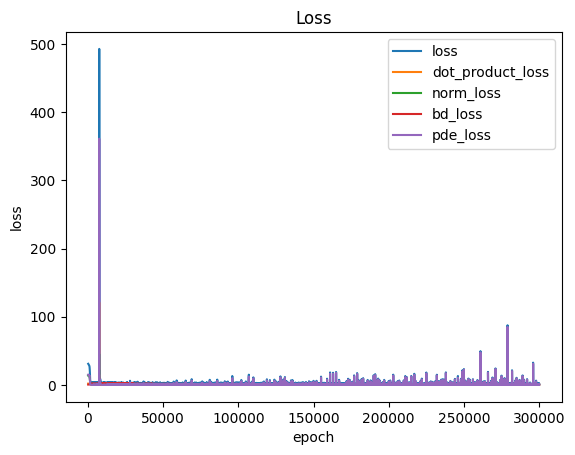

eigenval =  6.8033 7.147 4.7887
|u_1|^2=  0.46525067
|u_2|^2=  0.7847707
|u_3|^2=  0.90754014


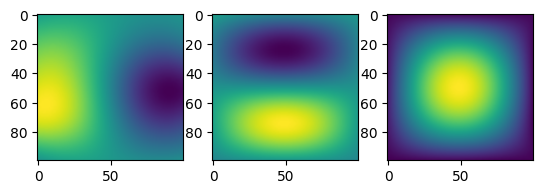

Training: 100%|██████████| 300001/300001 [3:10:17<00:00, 26.28it/s, loss=9.4210e-01]


In [8]:
# Петля обучения

from collections import defaultdict

n_points = 500
n_bd = 100

# весовые коэффиценты разных компонент лоса
bd_cf = 5
norm_cf = 1
pde_cf = 1
dot_cf = 5

scale = [0.5, 1]
x_int = generate_data_int(n_points, dim=2, sacle=scale)
x_b = generate_data_bd_2d(n_bd, scale)

epochs = 300000
pbar = trange(epochs + 1, desc="Training")
history = defaultdict(list)
for ep in pbar:
    if ep % 1000 == 0 and ep > 0:
        x_int = generate_data_int(n_points, dim=2, sacle=scale)
        x_b = generate_data_bd_2d(n_bd, scale)
    opt.zero_grad()

    u_int, l = model(x_int)
    u_b, _ = model(x_b)

    norm_loss = normal_loss(u_int)
    dp_loss = dot_product_loss(u_int)
    bd_loss = boundary_loss(u_b, condtion_type="zero")
    pde_loss = pde_laplace_2D_loss(x_int, l, u_int)

    loss = dot_cf * dp_loss + norm_cf * norm_loss + bd_cf * bd_loss + pde_cf * pde_loss
    loss.backward()
    opt.step()

    history["ep"].append(ep)
    history["loss"].append(float(loss.item()))
    history["dot_product_loss"].append(float(dot_cf * dp_loss.item()))
    history["norm_loss"].append(float(norm_cf * norm_loss.item()))
    history["bd_loss"].append(float(bd_cf * bd_loss.item()))
    history["pde_loss"].append(float(pde_cf * pde_loss.item()))
    if ep % 1000 == 0 and ep > 0:
        clear_output()
        draw_loss(history)
        print(
            "eigenval = ", " ".join(str(round(float(x), 4)) for x in (l / torch.pi**2))
        )

        draw_eigenfunc_2D(model, scale)

    pbar.set_postfix(loss=f"{loss.item():.4e}")